## Analyse coefficients dynamiques

Alexandre Castanié

---

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [10]:
#Récupération des données de la CRE
CoeffsCRE=pd.read_excel("2eme semestre 2022.xlsx",sheet_name=-1,skiprows=2)
CoeffsCRE = CoeffsCRE.set_index('Horodate')
CoeffsCRE.index = pd.to_datetime(CoeffsCRE.index)

Les données de la CRE sont composées des profils dynamiques i.e. des courbes de charge prévisionnelles à température normale et des gradients de température i.e. des coefficients qui permettent de prendre en compte les variations de température. Ces grandeurs s'expriment au pas du règlement des écarts fixé à 30 min pour l'instant.

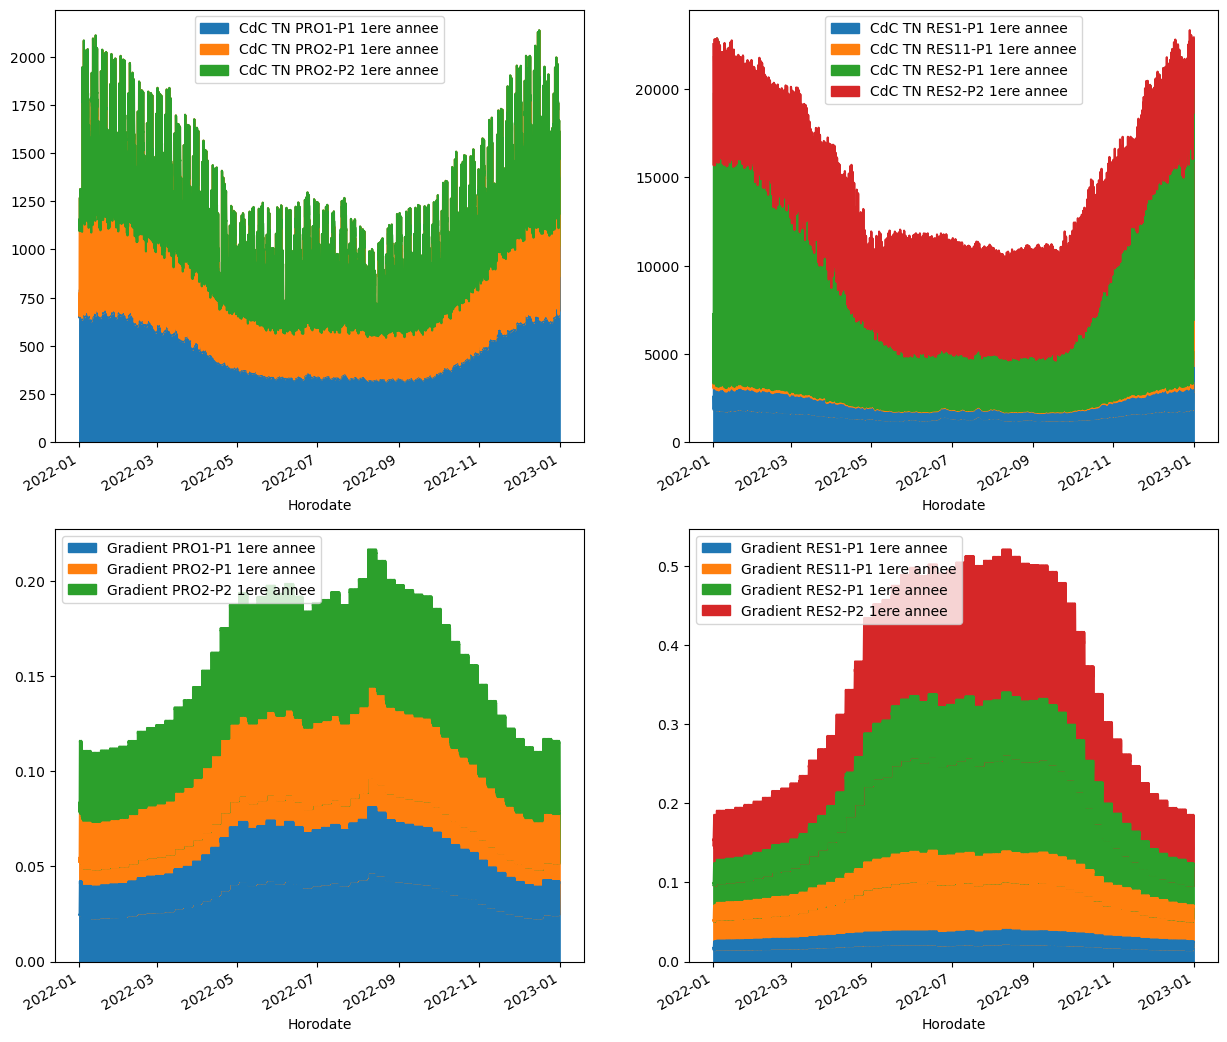

In [21]:
#Tracé données
fig,axs=plt.subplots(2,2,figsize=(15,14))
CoeffsCRE.plot.area(y=['CdC TN PRO1-P1 1ere annee','CdC TN PRO2-P1 1ere annee','CdC TN PRO2-P2 1ere annee'],ax=axs[0,0])
CoeffsCRE.plot.area(y=['CdC TN RES1-P1 1ere annee','CdC TN RES11-P1 1ere annee','CdC TN RES2-P1 1ere annee','CdC TN RES2-P2 1ere annee'],ax=axs[0,1])
CoeffsCRE.plot.area(y=['Gradient PRO1-P1 1ere annee','Gradient PRO2-P1 1ere annee','Gradient PRO2-P2 1ere annee'],ax=axs[1,0])
CoeffsCRE.plot.area(y=['Gradient RES1-P1 1ere annee','Gradient RES11-P1 1ere annee','Gradient RES2-P1 1ere annee','Gradient RES2-P2 1ere annee'],ax=axs[1,1])
plt.show()

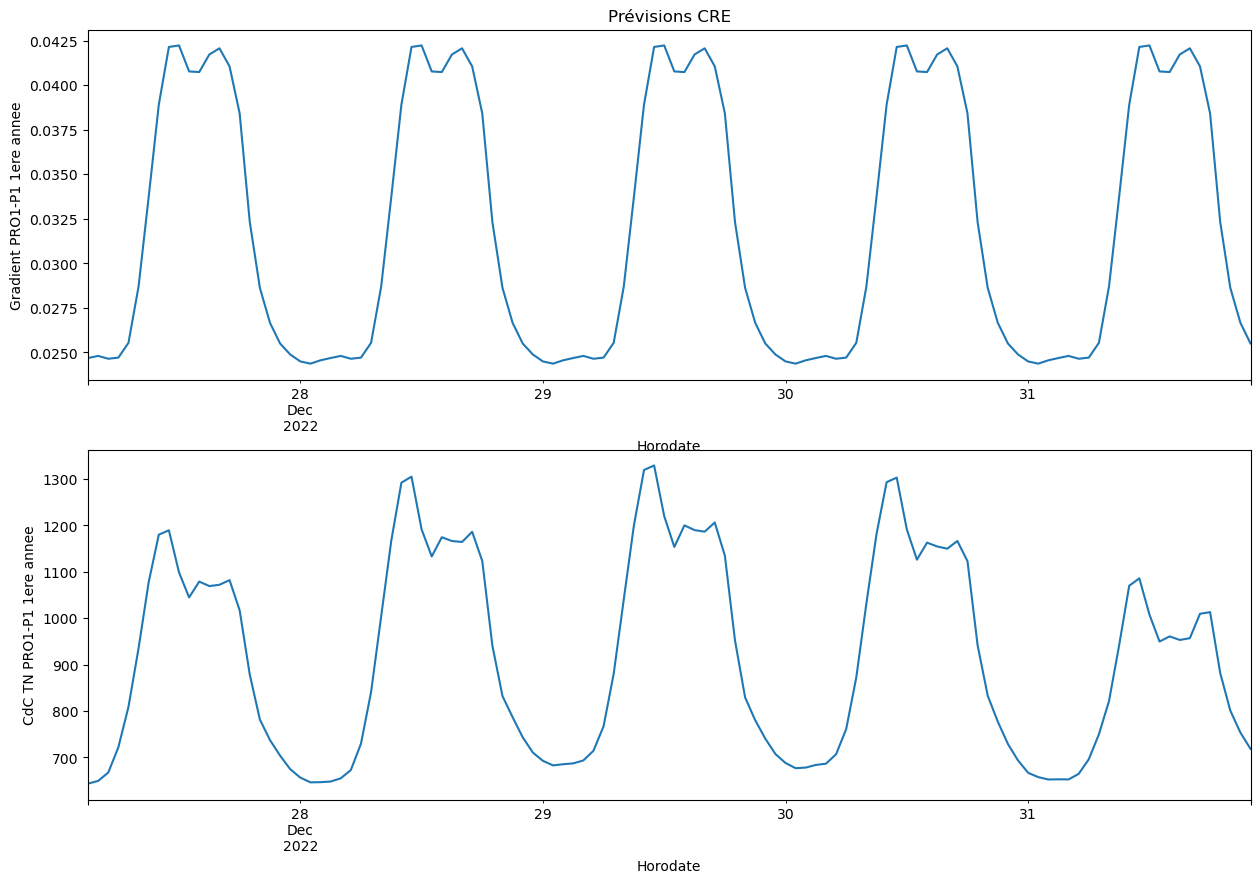

In [36]:
fig,axs=plt.subplots(2,1,figsize=(15,10))
CoeffsCRE['Gradient PRO1-P1 1ere annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[0], title='Prévisions CRE',ylabel='Gradient PRO1-P1 1ere annee')
CoeffsCRE['CdC TN PRO1-P1 1ere annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[1],ylabel='CdC TN PRO1-P1 1ere annee')
plt.show()